# **Utilization Prediction**

In [167]:
import keras
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Activation, Dense, Dropout, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
from sklearn.tree import export_graphviz

In [168]:
try:
    df = pd.read_pickle('resources/pickle_files/charging_sessions_prepared.pkl')
    print("Successfully imported charging_sessions_prepared.pkl")
except FileNotFoundError:
    print("Error: charging_sessions_prepared.pkl not found.")

try:
    weather_df = pd.read_pickle('resources/pickle_files/new_burbank_weather_data_prepared.pkl')
    print("Successfully imported new_burbank_weather_data_prepared.pkl")
except FileNotFoundError:
    print("Error: new_burbank_weather_data_prepared.pkl not found.")

Successfully imported charging_sessions_prepared.pkl
Successfully imported new_burbank_weather_data_prepared.pkl


In [169]:
df

,connectionTime,connectionDuration,chargingDuration,kWhDelivered,siteID,minutesAvailable,kWhRequested,WhPerMile,dayOfWeek,month,isHoliday,isPandemic
0,2020-01-02 05:08:54-08:00,6.039167,4.378056,25.016,1,463.0,25.00,250.0,Thursday,January,False,False
1,2020-01-02 05:36:50-08:00,9.025278,6.687500,33.097,1,595.0,70.00,280.0,Thursday,January,False,False
2,2020-01-02 05:56:35-08:00,10.713056,2.641944,6.521,1,60.0,8.00,400.0,Thursday,January,False,False
3,2020-01-02 05:59:58-08:00,2.644722,1.313056,2.355,1,65.0,8.00,400.0,Thursday,January,False,False
4,2020-01-02 06:00:01-08:00,8.144167,4.291389,13.375,1,504.0,16.00,400.0,Thursday,January,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
65032,2019-07-01 14:49:12-07:00,3.801667,1.422500,8.399,1,36.0,32.00,400.0,Monday,July,False,False
65033,2019-07-01 14:58:45-07:00,2.684167,2.693333,16.864,1,234.0,40.00,400.0,Monday,July,False,False
65034,2019-07-01 15:02:21-07:00,2.941389,2.950556,18.335,1,309.0,29.97,333.0,Monday,July,False,False
65035,2019-07-01 15:23:44-07:00,3.664444,3.672778,22.815,1,99.0,34.00,200.0,Monday,July,False,False


We now want preprocess our data and transform it in a way such that it is suitable to be used for neural networks and other machine learning methods. First of, we define our measure for utilization, our **target**. We came up with two ways of doing so, namely the number of active sessions per hour and the kWhDelivered per hour, and after some discussions we decided on using the hourly *kWhDelivered*, reason being that we expect to have a more accurate representation of the actual demand.

To achieve this, we distribute the *kWhDelivered* of each charging session evenly over its duration. For example, if a charging session starts at exactly 1pm and ends at exactly 4pm (and thus lasting 3 hours) with a kWhDelivered of 12, we add 4 kWh for each hour (for 1PM - 2PM, 2PM - 3PM and 3PM - 4PM). We construct this new dataframe by going through our whole dataset and distributing the kWhDelivered evenly over the charging duration (not connection duration) by splitting each charging session into 5min intervals (because of computational reasons) and afterwards, aggregating by the hour and the site id by which we get our hourly energy consumption for each of the sites.

In [170]:
def distribute_kwh_hourly_with_site(df):
    df['end_time'] = df['connectionTime'] + pd.to_timedelta(df['chargingDuration'], unit='h')
    df['intervals'] = df.apply(
        lambda row: pd.date_range(
            start=row['connectionTime'],
            end=row['end_time'],
            freq='5min',
            inclusive='left',
            ambiguous=True
        ),
        axis=1
    )
    exploded_df = df.explode('intervals')
    exploded_df = exploded_df.dropna(subset=['intervals'])
    exploded_df['hour'] = exploded_df['intervals'].dt.tz_localize(None).dt.floor('h').dt.tz_localize('America/Los_Angeles', ambiguous=True)
    exploded_df = exploded_df.dropna(subset=['hour'])
    exploded_df['kWhDelivered'] = exploded_df['kWhDelivered'] / exploded_df.groupby(level=0)['intervals'].transform('count')
    
    hourly_aggregated_df = (
        exploded_df.groupby(['hour', 'siteID'], as_index=False)
        .agg({'kWhDelivered': 'sum'})
    )
    
    all_hours = pd.date_range(
        start=hourly_aggregated_df['hour'].min(),
        end=hourly_aggregated_df['hour'].max(),
        freq='h'
    )
    
    all_hours_df = pd.DataFrame(all_hours, columns=['hour'])
    
    all_combinations = [(hour, site_id) for hour in all_hours for site_id in [1, 2]]
    all_combinations_df = pd.DataFrame(all_combinations, columns=['hour', 'siteID'])
    
    hourly_complete_df = pd.merge(all_combinations_df, hourly_aggregated_df, on=['hour', 'siteID'], how='left')
    
    hourly_complete_df['kWhDelivered'] = hourly_complete_df['kWhDelivered'].fillna(0)
    
    return hourly_complete_df


hourly_aggregated_df = distribute_kwh_hourly_with_site(df)
hourly_aggregated_df

,hour,siteID,kWhDelivered
0,2018-04-25 04:00:00-07:00,1,0.000000
1,2018-04-25 04:00:00-07:00,2,3.231556
2,2018-04-25 05:00:00-07:00,1,0.000000
3,2018-04-25 05:00:00-07:00,2,3.525333
4,2018-04-25 06:00:00-07:00,1,0.000000
...,...,...,...
59427,2021-09-14 05:00:00-07:00,2,0.000000
59428,2021-09-14 06:00:00-07:00,1,5.938018
59429,2021-09-14 06:00:00-07:00,2,0.000000
59430,2021-09-14 07:00:00-07:00,1,4.453514


Since this computation takes a lot of time, we will pickle it.

In [171]:
hourly_aggregated_df.to_pickle("resources/pickle_files/charging_sessions_aggregated_hourly_5min_resolution.pkl")

<Axes: xlabel='hour'>

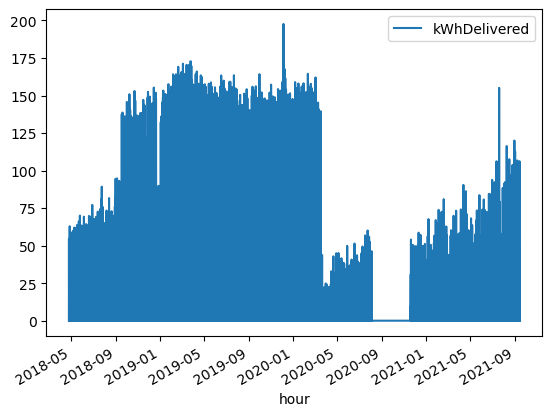

In [172]:
hourly_aggregated_df = pd.read_pickle("resources/pickle_files/charging_sessions_aggregated_hourly_5min_resolution.pkl")
hourly_aggregated_df.plot(x='hour',y='kWhDelivered')

Now we combine the hourly energy data with the weather data.

In [173]:
combined_df = pd.merge(
    hourly_aggregated_df,
    weather_df,
    on='hour',
    how='left'
)

combined_df.to_csv('resources/csv_files/combined.csv')
combined_df

,hour,siteID,kWhDelivered,temperature,clouds,pressure,windspeed,precipitation,felt_temperature,windy,...,wx_phrase_Haze,wx_phrase_Heavy Rain,wx_phrase_Heavy T-Storm,wx_phrase_Light Rain,wx_phrase_Mostly Cloudy,wx_phrase_Partly Cloudy,wx_phrase_Rain,wx_phrase_Smoke,wx_phrase_T-Storm,wx_phrase_Thunder in the Vicinity
0,2018-04-25 04:00:00-07:00,1,0.000000,12.0,3.0,989.11,6.0,0.0,12.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,2018-04-25 04:00:00-07:00,2,3.231556,12.0,3.0,989.11,6.0,0.0,12.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2,2018-04-25 05:00:00-07:00,1,0.000000,12.0,3.0,989.11,8.0,0.0,12.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,2018-04-25 05:00:00-07:00,2,3.525333,12.0,3.0,989.11,8.0,0.0,12.0,0.0,...,False,False,False,False,True,False,False,False,False,False
4,2018-04-25 06:00:00-07:00,1,0.000000,12.0,4.0,989.44,8.0,0.0,12.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59427,2021-09-14 05:00:00-07:00,2,0.000000,16.0,0.0,984.50,7.0,0.0,16.0,0.0,...,False,False,False,False,False,False,False,False,False,False
59428,2021-09-14 06:00:00-07:00,1,5.938018,15.0,0.0,985.16,6.0,0.0,15.0,0.0,...,False,False,False,False,False,False,False,False,False,False
59429,2021-09-14 06:00:00-07:00,2,0.000000,15.0,0.0,985.16,6.0,0.0,15.0,0.0,...,False,False,False,False,False,False,False,False,False,False
59430,2021-09-14 07:00:00-07:00,1,4.453514,16.0,0.0,985.49,0.0,0.0,16.0,0.0,...,False,False,False,False,False,False,False,False,False,False


After combining both data sources, we check for null values:

In [174]:
print(len(combined_df[combined_df.isna().any(axis=1)]))
print(combined_df['kWhDelivered'].isna().sum())

220
0


We see that there are null values, but none of them are from the kWhDelivered. Thus, they are caused by missing weather data. Since we don't expect weather to change too much over an hour, we will just use backfill.

In [175]:
combined_df = combined_df.bfill()

/tmp/ipykernel_1788721/3478079209.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df = combined_df.bfill()


Now we need to transform the **time** data we got. Encoding the day of the week or the month of the year as numerical features by assigning them their corresponding numbers (i.e., January = 1, February = 2), we would lose the cyclic nature of the time and we wouldn't encode the information that January is equally close to February as December. To model this cyclical behavior, we will use the sine and cosine transformation for these time features:

In [176]:
combined_df['sin_hourOfDay'] = np.sin(combined_df['hour'].dt.hour * np.pi * 2 / 24)
combined_df['cos_hourOfDay'] = np.cos(combined_df['hour'].dt.hour * np.pi * 2 / 24)
combined_df['sin_day'] = np.sin(combined_df['hour'].dt.dayofweek * np.pi * 2 / 7)
combined_df['cos_day'] = np.cos(combined_df['hour'].dt.dayofweek * np.pi * 2 / 7)
combined_df['sin_month'] = np.sin(combined_df['hour'].dt.month * np.pi * 2 / 12)
combined_df['cos_month'] = np.cos(combined_df['hour'].dt.month * np.pi * 2 / 12)

We have also lost the *isPandemic* and *isHoliday* feature we initially engineered because of our aggregation. Since we expect those to be helpful in our predictive model, we will add them again.

In [177]:
combined_df.loc[:, 'isPandemic'] = combined_df['hour'] >= '2020-03-13'

holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
    "2018-09-03", "2018-11-11", "2018-11-22", "2018-11-23", "2018-12-25",

    "2019-01-01", "2019-01-21", "2019-02-18", "2019-05-27", "2019-07-04",
    "2019-09-02", "2019-11-11", "2019-11-28", "2019-11-29", "2019-12-25",

    "2020-01-01", "2020-01-20", "2020-02-17", "2020-05-25", "2020-07-04",
    "2020-09-07", "2020-11-11", "2020-11-26", "2020-11-27", "2020-12-25",

    "2021-01-01", "2021-01-18", "2021-02-15", "2021-05-31", "2021-07-04",
    "2021-09-06", "2021-11-11", "2021-11-25", "2021-11-26", "2021-12-25",
]
holidays = [pd.to_datetime(date).date() for date in holidays]

combined_df.loc[:, 'isHoliday'] = combined_df['hour'].dt.date.isin(holidays)

In [178]:
combined_df

,hour,siteID,kWhDelivered,temperature,clouds,pressure,windspeed,precipitation,felt_temperature,windy,...,wx_phrase_T-Storm,wx_phrase_Thunder in the Vicinity,sin_hourOfDay,cos_hourOfDay,sin_day,cos_day,sin_month,cos_month,isPandemic,isHoliday
0,2018-04-25 04:00:00-07:00,1,0.000000,12.0,3.0,989.11,6.0,0.0,12.0,0.0,...,False,False,0.866025,5.000000e-01,0.974928,-0.222521,0.866025,-5.000000e-01,False,False
1,2018-04-25 04:00:00-07:00,2,3.231556,12.0,3.0,989.11,6.0,0.0,12.0,0.0,...,False,False,0.866025,5.000000e-01,0.974928,-0.222521,0.866025,-5.000000e-01,False,False
2,2018-04-25 05:00:00-07:00,1,0.000000,12.0,3.0,989.11,8.0,0.0,12.0,0.0,...,False,False,0.965926,2.588190e-01,0.974928,-0.222521,0.866025,-5.000000e-01,False,False
3,2018-04-25 05:00:00-07:00,2,3.525333,12.0,3.0,989.11,8.0,0.0,12.0,0.0,...,False,False,0.965926,2.588190e-01,0.974928,-0.222521,0.866025,-5.000000e-01,False,False
4,2018-04-25 06:00:00-07:00,1,0.000000,12.0,4.0,989.44,8.0,0.0,12.0,0.0,...,False,False,1.000000,6.123234e-17,0.974928,-0.222521,0.866025,-5.000000e-01,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59427,2021-09-14 05:00:00-07:00,2,0.000000,16.0,0.0,984.50,7.0,0.0,16.0,0.0,...,False,False,0.965926,2.588190e-01,0.781831,0.623490,-1.000000,-1.836970e-16,True,False
59428,2021-09-14 06:00:00-07:00,1,5.938018,15.0,0.0,985.16,6.0,0.0,15.0,0.0,...,False,False,1.000000,6.123234e-17,0.781831,0.623490,-1.000000,-1.836970e-16,True,False
59429,2021-09-14 06:00:00-07:00,2,0.000000,15.0,0.0,985.16,6.0,0.0,15.0,0.0,...,False,False,1.000000,6.123234e-17,0.781831,0.623490,-1.000000,-1.836970e-16,True,False
59430,2021-09-14 07:00:00-07:00,1,4.453514,16.0,0.0,985.49,0.0,0.0,16.0,0.0,...,False,False,0.965926,-2.588190e-01,0.781831,0.623490,-1.000000,-1.836970e-16,True,False


Now we have transformed and encoded all of our necessary features for our models. Thus, we can finally drop the *hour* column.

In [179]:
combined_df = combined_df.drop(columns=['hour'])

# **Neural Networks**

We seperate our target from the data set.

In [180]:
X = combined_df.drop(columns=['kWhDelivered'])
y = combined_df['kWhDelivered']

Now we will construct a training / holdout split and train our neural network on it!

In [181]:
def data():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    numerical_cols = ['temperature', 'pressure', 'windspeed',
                      'precipitation', 'felt_temperature', 'clouds', 'sin_hourOfDay',
                      'cos_hourOfDay', 'sin_day', 'cos_day', 'sin_month', 'cos_month']
    categorical_cols = X_train.columns.difference(numerical_cols)

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_categorical = encoder.fit_transform(X_train[categorical_cols])
    X_test_categorical = encoder.transform(X_test[categorical_cols])

    scaler = StandardScaler()
    X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_cols])
    X_test_numerical_scaled = scaler.transform(X_test[numerical_cols])

    X_train_scaled = np.hstack([X_train_numerical_scaled, X_train_categorical])
    X_test_scaled = np.hstack([X_test_numerical_scaled, X_test_categorical])

    X_train_scaled = pd.DataFrame(
        data=X_train_scaled,
        columns=list(numerical_cols) + list(encoder.get_feature_names_out(categorical_cols)),
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        data=X_test_scaled,
        columns=list(numerical_cols) + list(encoder.get_feature_names_out(categorical_cols)),
        index=X_test.index
    )
    return X_train_scaled, y_train, X_test_scaled, y_test


def create_model(x_train, y_train, x_test, y_test):
    input_shape = x_train.shape[1]
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    model.compile(loss='mse', metrics=['mae'],
               optimizer='adam')
    
    result = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )
    return model

In [182]:
X_train, Y_train, X_test, Y_test = data()
model = create_model(X_train, Y_train, X_test, Y_test)

Epoch 1/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 385.5206 - mae: 10.9073 - val_loss: 218.0317 - val_mae: 8.2236
Epoch 2/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 224.0110 - mae: 8.1933 - val_loss: 202.6756 - val_mae: 7.5154
Epoch 3/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 208.5653 - mae: 7.7601 - val_loss: 196.0975 - val_mae: 7.2250
Epoch 4/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 196.3038 - mae: 7.4797 - val_loss: 196.8369 - val_mae: 7.5779
Epoch 5/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 193.4620 - mae: 7.4841 - val_loss: 195.9001 - val_mae: 7.2249
Epoch 6/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 188.7113 - mae: 7.4084 - val_loss: 196.5869 - val_mae: 7.2232
Epoch 7/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 184.1455 - mae: 7.3278 - val_loss: 188.6674 - val_mae: 7.2330
Epoch 8/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 190.1550 - mae: 7.4106 - val_loss: 186.0367 - val_mae: 7.2032
Epoch 9

## Decision Trees

Now we also train a decision tree model and evaluate both of them on the same holdout set.

In [183]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred_nn = model.predict(X_test)
y_pred_tree = clf.predict(X_test)
print(f"nn mae = {mean_absolute_error(y_test, y_pred_nn)}")
print(f"nn mse = {mean_squared_error(y_test, y_pred_nn)}")
print(f"nn r2 = {r2_score(y_test, y_pred_nn)}")
print(f"tree mae = {mean_absolute_error(y_test, y_pred_tree)}")
print(f"tree mse = {mean_squared_error(y_test, y_pred_tree)}")
print(f"tree r2 = {r2_score(y_test, y_pred_tree)}")

558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
nn mae = 6.511742732591246
nn mse = 153.77985208727068
nn r2 = 0.7587128199509108
tree mae = 7.7879422916891
tree mse = 287.3780700367984
tree r2 = 0.5490914889957259
